In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision import models

class Net(nn.Module):
    def __init__(self, lr, epochs, batch_size, num_classes=10):
        super(Net, self).__init__()
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.t_loss_history = []
        self.v_loss_history = []# βαζω avg losses
        self.acc_history = []
        self.v_acc_history = []
        self.valid_loss_min = np.Inf #using this high value to make sure the update the weight first time


        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)# batch normalization 
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3)
        self.bn6 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)

        input_dims = self.calc_input_dims()

        self.fc1 = nn.Linear(input_dims, self.num_classes)

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

        self.to(self.device)
        self.get_data()
        #self.show_batch()

    def calc_input_dims(self):
        x = torch.zeros((1, 1, 28, 28))
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.conv3(x)

        x = self.maxpool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool2(x)

        return int(np.prod(x.size()))

    def forward(self, x):
        x = torch.tensor(x).to(self.device)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout(F.relu(x))

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout(F.relu(x))

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout(F.relu(x))

        x = self.maxpool1(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.dropout(F.relu(x))

        x = self.conv5(x)

        x = self.bn5(x)
        x = self.dropout(F.relu(x))
        x = self.conv6(x)

        x = self.bn6(x)
        x = self.dropout(F.relu(x))
        x = self.maxpool2(x)

        x = x.view(x.size()[0], -1)

        classes = self.fc1(x)

        return classes


    def get_data(self):
        train_data = FashionMNIST('mnist', train=True,
                                 download=True, transform=ToTensor())
        self.train_data_loader = torch.utils.data.DataLoader(train_data,
                                                    batch_size=self.batch_size,
                                                    shuffle=True,
                                                    num_workers=8)
        test_data = FashionMNIST('mnist', train=False,
                                 download=True, transform=ToTensor())
        self.test_data_loader = torch.utils.data.DataLoader(test_data,
                                                    batch_size=self.batch_size,
                                                    shuffle=True,
                                                    num_workers=8)

    def show_batch(self):
      for images, labels in self.train_data_loader:
          fig, ax = plt.subplots(figsize = (16,12))
          ax.set_xticks([])
          ax.set_yticks([])
          ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
          break

class ResNet50(Net):
  def __init__(self, lr, epochs, batch_size, num_classes=10):
    super(Net, self).__init__()
    self.epochs = epochs
    self.lr = lr
    self.batch_size = batch_size
    self.num_classes = num_classes
    self.t_loss_history = []
    self.v_loss_history = []
    self.acc_history = []
    self.v_acc_history = []
    self.valid_loss_min = np.Inf #using this high value to make sure the update the weight first time


    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')        
    self.model = models.resnet50(pretrained=True)
    print(self.model)
  
    for param in self.model.parameters():
      param.requires_grad = False
    
    # classifier sto telos
    self.model.fc = nn.Sequential(nn.Linear(2048, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 10))    
    for (name, module) in self.model.named_children():
      print(name)
      # ta layer pou kanei unfreeze  
      if name in ["layer3","layer4","avgpool","fc"]:
          for layer in module.children():
              for param in layer.parameters():
                  param.requires_grad = True
    
    self.optimizer = optim.Adam(filter(lambda p: p.requires_grad,self.model.parameters()), lr=self.lr)

    #self.loss = nn.CrossEntropyLoss()
    self.to(self.device)
    self.get_data()

  def forward(self, x):
    x = np.repeat(x, 3, axis=1) # se rgb oi eikones giati to resnet pairnei rgb 

    x = x.to(self.device)
    return self.model.forward(x)

class ResNet18(Net):
  def __init__(self, lr, epochs, batch_size, num_classes=10):
    super(Net, self).__init__()
    self.epochs = epochs
    self.lr = lr
    self.batch_size = batch_size
    self.num_classes = num_classes
    self.t_loss_history = []
    self.v_loss_history = []
    self.acc_history = []
    self.v_acc_history = []
    self.valid_loss_min = np.Inf #using this high value to make sure the update the weight first time


    self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')        
    self.model = models.resnet18(pretrained=False)
    print(self.model)
  
    for param in self.model.parameters():
      param.requires_grad = True
    fc1 = nn.Linear(512, 256)
    fc2 = nn.Linear(256, 128)
    fc3 = nn.Linear(128, 10)

    layers = [fc1, fc2, fc3]
    """
    for linearLayer in layers:
        #Applying He initialization to all layers
        nn.init.kaiming_uniform_(linearLayer.weight, nonlinearity='relu')
    """

    #Setting Resnet's fully connected layer to our collection of three Linear layers with nn.Sequential
    self.model.fc = nn.Sequential(fc1, nn.ReLU(),nn.Dropout(0.4),fc2, nn.ReLU(),fc3)
    
    self.optimizer = optim.Adam(filter(lambda p: p.requires_grad,self.model.parameters()), lr=self.lr)

    #self.loss = nn.CrossEntropyLoss()
    self.to(self.device)
    self.get_data()

  def forward(self, x):
    x = np.repeat(x, 3, axis=1)

    x = x.to(self.device)
    return self.model.forward(x)

"""    
if __name__ == '__main__':
    network = Net(lr=0.001, batch_size=64, epochs=25)
    print(network)
    #network = ResNet50(lr=0.001, batch_size=128, epochs=25)
    #network.show_batch()
    network._train()
    plt.plot(network.t_loss_history, label= "Training Loss")
    plt.plot(network.v_loss_history, label= "Validation Loss")
    plt.legend()
    plt.show()
    plt.plot(network.v_acc_history)
    plt.show()
    #network._test()
"""    

'    \nif __name__ == \'__main__\':\n    network = Net(lr=0.001, batch_size=64, epochs=25)\n    print(network)\n    #network = ResNet50(lr=0.001, batch_size=128, epochs=25)\n    #network.show_batch()\n    network._train()\n    plt.plot(network.t_loss_history, label= "Training Loss")\n    plt.plot(network.v_loss_history, label= "Validation Loss")\n    plt.legend()\n    plt.show()\n    plt.plot(network.v_acc_history)\n    plt.show()\n    #network._test()\n'

In [ ]:
def _train(model):
    """
    I designed one scheduler for each one of my experiments. When running one experiment comment out the other 
    2 schedulers. e.g. When running Experiment 1 comment out schedulers for experiments 2, 3.
    """
    ###Experiment 1: My own CNN model architecture### 
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer,step_size=20, gamma=0.5)
    ###Experiment 2: ResNet50 pretrained on ImageNet with last layers unfrozen### 
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(model.optimizer, gamma=0.1, last_epoch=-1)
    ###Experiment 3: ResNet18 trained from the start###
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(model.optimizer,milestones=[4,6,8], gamma=0.1) # 0,1*lr στα 4,6,8 βημάτα 

## idio gia ola ta dixtia
    for i in range(model.epochs): 
        model.train()
        ep_loss = 0
        ep_acc = []
        for j, (input, label) in enumerate(model.train_data_loader):
            #print('in:',input,'lbl:',label)
            label = label.to(model.device)
            preds = model.forward(input)
            #print(prediction)
            #loss = model.loss(preds, label)
            loss = F.cross_entropy(preds, label)
            preds = F.softmax(preds, dim=1)

            classes = torch.argmax(preds, dim=1)
            '''
            #print(classes)
            wrong = torch.where(classes != label,
                            torch.tensor([1.]).to(self.device),
                            torch.tensor([0.]).to(self.device))
            acc = 1 - torch.sum(wrong) / self.batch_size
            '''
            acc = torch.tensor(torch.sum(classes == label).item() / len(classes))
            ep_acc.append(acc.item())
            ep_loss += loss.item()
            loss.backward()
            model.optimizer.step()
            model.optimizer.zero_grad()

        avg_tloss = ep_loss / (j + 1)
        print('Finish epoch ', i, 'training loss %.3f' % avg_tloss,
                'training accuracy %.3f' % np.mean(ep_acc))
        model.t_loss_history.append(avg_tloss)
        model.acc_history.append(np.mean(ep_acc))

        _eval(model)
        scheduler.step()

def _eval(model):# στο model που δημιουργηθηκε από το train μιας εποχης βαζω input το test set
    model.eval()

    ep_loss = 0
    ep_acc = []
    for j, (input, label) in enumerate(model.test_data_loader):
        label = label.to(model.device)
        preds = model.forward(input)
        loss = F.cross_entropy(preds, label)
        preds = F.softmax(preds, dim=1)

        classes = torch.argmax(preds, dim=1)
        acc = torch.tensor(torch.sum(classes == label).item() / len(classes))

        ep_acc.append(acc.item())
        #self.v_acc_history.append(acc.item())

        ep_loss += loss.item()
    avg_loss = ep_loss / (j + 1)

    print('validation loss %.3f' % avg_loss,
            'validation accuracy %.3f' % np.mean(ep_acc))
    model.v_loss_history.append(avg_loss)
    model.v_acc_history.append(np.mean(ep_acc))
    if avg_loss <= model.valid_loss_min: # κραταει το μικροτερο loss που έχω δει στο validation set
        print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(model.valid_loss_min, avg_loss))
        torch.save(model.state_dict(), 'model.pt')
        model.valid_loss_min = avg_loss
    #return ep_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


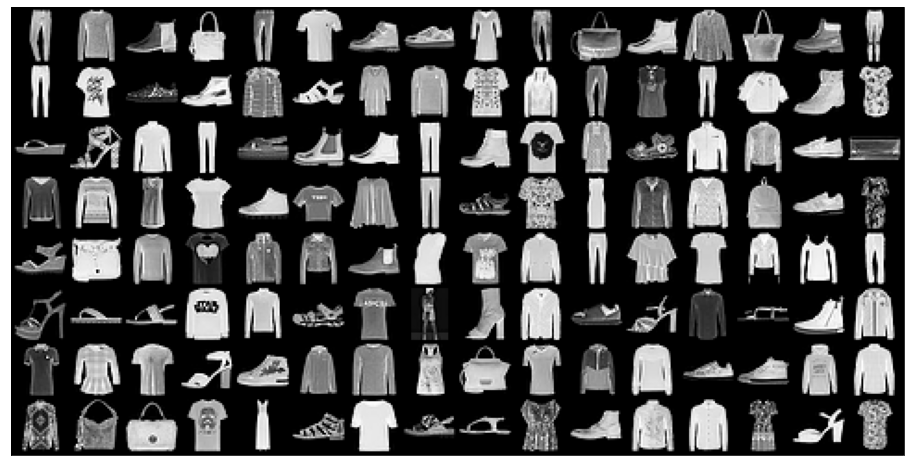

In [ ]:
"""
To run one experiment, you have to comment out the other 2 definitions of networks.
e.g. To run Experiment 1 with my own CNN model comment out:
network=ResNet50(...)
network=ResNet18(...)
""" 
network = Net(lr=0.001, batch_size=128, epochs=50)
#print(network)
#network = ResNet50(lr=0.0003, batch_size=128, epochs=10)
#network=ResNet18(lr=0.001, batch_size=128, epochs=15)
network.show_batch()


***Training of our models***

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Finish epoch  0 training loss 0.545 training accuracy 0.798
validation loss 0.428 validation accuracy 0.858
validation loss decreased(inf -->0.427972). Saving Model ...
Finish epoch  1 training loss 0.346 training accuracy 0.874
validation loss 0.374 validation accuracy 0.867
validation loss decreased(0.427972 -->0.374191). Saving Model ...
Finish epoch  2 training loss 0.302 training accuracy 0.890
validation loss 0.371 validation accuracy 0.866
validation loss decreased(0.374191 -->0.370839). Saving Model ...
Finish epoch  3 training loss 0.280 training accuracy 0.898
validation loss 0.288 validation accuracy 0.903
validation loss decreased(0.370839 -->0.288162). Saving Model ...
Finish epoch  4 training loss 0.261 training accuracy 0.905
validation loss 0.301 validation accuracy 0.893
Finish epoch  5 training loss 0.250 training accuracy 0.909
validation loss 0.287 validation accuracy 0.894
validation loss decreased(0.288162 -->0.286949). Saving Model ...
Finish epoch  6 training lo

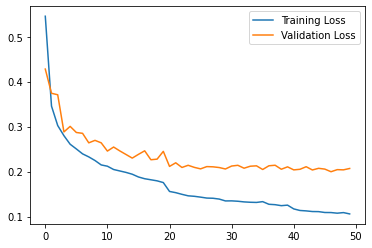

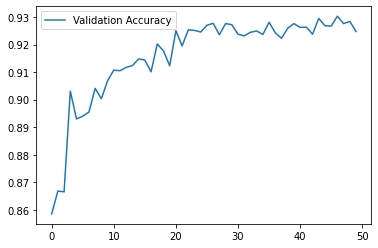

In [ ]:
_train(network)
plt.plot(network.t_loss_history, label = "Training Loss")
plt.plot(network.v_loss_history, label = "Validation Loss")
plt.legend()
plt.savefig("losses.png")
plt.show()
plt.plot(network.v_acc_history, label = "Validation Accuracy")
plt.legend()
plt.savefig("accuracy.png")
plt.show()

***Loading the trained model parameters and calculating stats***

In [ ]:
"""
To load one model's parameters, you have to comment out the other 2 definitions of networks.
e.g. To load my own CNN model's parameters comment out:
network=ResNet50(...)
network=ResNet18(...)
""" 
network = Net(lr=0.001, batch_size=128, epochs=50)
#print(network)
#network = ResNet50(lr=0.0003, batch_size=128, epochs=10)
#network=ResNet18(lr=0.001, batch_size=128, epochs=15)

In [ ]:
network.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


network.eval()
for input, labels in network.test_data_loader:
  #forward pass 
  labels = labels.to(network.device)
  preds = network(input)
  loss = F.cross_entropy(preds, labels)
  test_loss += loss.item()*input.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(preds, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(network.test_data_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %.2f%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % class_total[i])

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Loss: 0.201865

Test Accuracy of     0: 87.00% (870/1000)
Test Accuracy of     1: 97.90% (979/1000)
Test Accuracy of     2: 91.80% (918/1000)
Test Accuracy of     3: 93.20% (932/1000)
Test Accuracy of     4: 88.40% (884/1000)
Test Accuracy of     5: 96.20% (962/1000)
Test Accuracy of     6: 81.40% (814/1000)
Test Accuracy of     7: 98.90% (989/1000)
Test Accuracy of     8: 98.80% (988/1000)
Test Accuracy of     9: 95.90% (959/1000)

Test Accuracy (Overall): 92.95% (9295/10000)


In [ ]:
@torch.no_grad()
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    for images,labels in dataloader:
        preds = network(images) 
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)
        preds = preds.cpu()
        all_preds = torch.cat((all_preds, preds), dim=0)
    print (all_preds)    
    return all_preds

In [ ]:
test_data = FashionMNIST('mnist', train=False,
                                 download=True, transform=ToTensor())
test_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=test_data, num_workers=1)
all_preds_test = get_all_preds(network, test_data_loader) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([9., 2., 1.,  ..., 8., 1., 5.])


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('F1: {}'.format(f1_score(test_data.targets, all_preds_test, average="weighted")))
print('Precision: {}'.format(precision_score(test_data.targets, all_preds_test, average="weighted")))
print('Recall: {}'.format(recall_score(test_data.targets, all_preds_test, average="weighted")))

F1: 0.9297026690001451
Precision: 0.9302930188425104
Recall: 0.9295


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


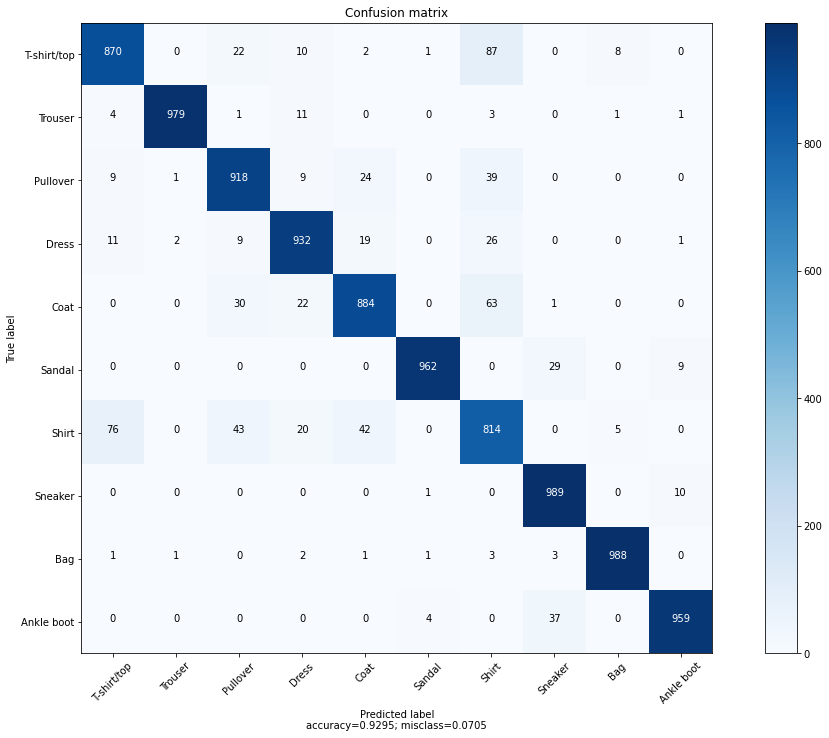

In [ ]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(y_true=test_data.targets, y_pred=all_preds_test), target_names=test_data.classes, normalize=False)

### Vision transormer

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 34.4 MB/s 
     |████████████████████████████████| 6.6 MB 46.4 MB/s 
     |████████████████████████████████| 120 kB 59.7 MB/s 


In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer
from PIL import Image
import requests



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
           0.0000, 0.0000, 0.1608, 0.7373, 0.4039, 0.2118, 0.1882, 0.1686,
           0.3412, 0.6588, 0.5216, 0.0627, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0000, 0.1922,
           0.5333, 0.8588, 0.8471, 0.8941, 0.9255, 1.0000, 1.0000, 1.0000,
           1.0000, 0.8510, 0.8431, 0.9961, 0.9059, 0.6275, 0.1765, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0549, 0.6902, 0.8706,
           0.8784, 0.8314, 0.7961, 0.7765, 0.7686, 0.7843, 0.8431, 0.8000,
           0.7922, 0.7882, 0.7882, 0.7882, 0.8196, 0.8549, 0.8784, 0.6431,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7373, 0.8588, 0.7843,
           0.7765, 0.7922, 0.7765, 0.7804, 0.7804, 0.7882, 0.7686, 0.7765,
           0.7765, 0.7843, 0.7843, 0.7843, 

In [3]:
!pip install -q transformers datasets
from datasets import load_dataset

ds = load_dataset('fashion_mnist')
ds=ds.rename_column("label", "labels")

     |████████████████████████████████| 365 kB 30.5 MB/s 
     |████████████████████████████████| 212 kB 65.1 MB/s 
     |████████████████████████████████| 115 kB 67.2 MB/s 
     |████████████████████████████████| 127 kB 76.0 MB/s 


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def fix_error(example):

    #print(type(example['image']))
    example['image'] = np.array(example['image'])
    example['image'] = np.repeat(example['image'][:, :, np.newaxis], 3, axis=2)
    #example['image']=Image.fromarray(example['image'])
    return example
    #print(type(example['image']))
import numpy as np
ds = ds.map(fix_error)
next(iter(ds["train"]))

  0%|          | 0/60000 [00:00<?, ?ex/s]

  0%|          | 0/10000 [00:00<?, ?ex/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=28x28 at 0x7F95F12391D0>,
 'labels': 9}

In [5]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 10000
    })
})


In [6]:
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [7]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [8]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [9]:
prepared_ds = ds.with_transform(transform)

In [10]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 10000
    })
})

In [11]:
prepared_ds['train'][0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'labels': 9}

In [12]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [13]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [14]:
labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
 
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 60000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 15000


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
import torch
dataloader = torch.utils.data.DataLoader(prepared_ds["test"],collate_fn=collate_fn, batch_size=100)
next(iter(dataloader))

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1.,

In [ ]:
(prepared_ds['test']['image'])

KeyboardInterrupt: ignored

In [ ]:
'''
from datasets import load_metric
metric = load_metric('accuracy', 'precision','f1','recall')
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Model evaluation

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
        2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2])
tensor([3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9,
        3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6,
        2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5,
        2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2,
        8, 3, 6, 1])
tensor([1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0,
        7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 6, 8, 6, 4,
        2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3,
        0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5

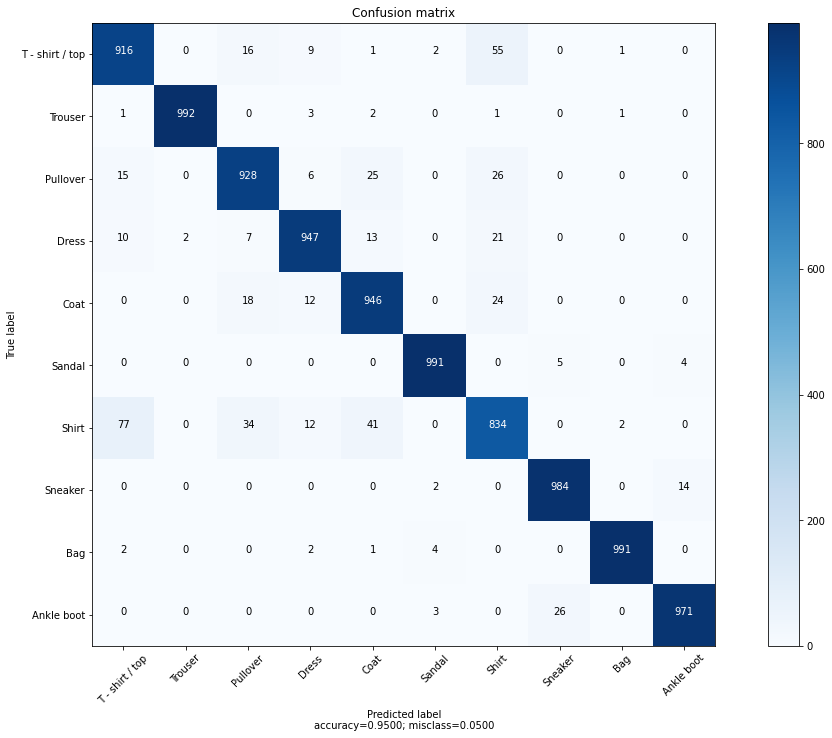

'\nfinal_score = metric.compute(predictions=model_predictions, references=gold_references)\nfinal_score\n'

In [ ]:
from matplotlib.scale import LogisticTransform
@torch.no_grad()
def get_all_preds(model,feature_extractor, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    all_labels=torch.tensor([])
    for inputs in dataloader:
        print(inputs['labels'])
        #inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx=torch.argmax(logits, dim=1)
        #predicted_class_idx = logits.argmax(-1).item()
        #print("Predicted class:", model.config.id2label[predicted_class_idx])
        all_preds = torch.cat((all_preds, predicted_class_idx), dim=0)
        all_labels=torch.cat((all_labels,inputs['labels']),dim=0)
    print (all_preds)    
    return all_preds,all_labels

from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained("/content/drive/MyDrive/checkpoint")
all_preds_test, all_labels = get_all_preds(model, feature_extractor,dataloader) 


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

from sklearn.metrics import confusion_matrix
plot_confusion_matrix(cm=confusion_matrix(y_true=all_labels, y_pred=all_preds_test), target_names=ds['test'].features["labels"].names, normalize=False)


'''
final_score = metric.compute(predictions=model_predictions, references=gold_references)
final_score
'''

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('F1: {}'.format(f1_score(all_labels, all_preds_test, average="weighted")))
print('Precision: {}'.format(precision_score(all_labels, all_preds_test, average="weighted")))
print('Recall: {}'.format(recall_score(all_labels, all_preds_test, average="weighted")))

F1: 0.9498961904461727
Precision: 0.9499417245054823
Recall: 0.95
